# Simulations for approximating Benzhaf-Penrose index for special cases

In this notebook, we run experiments and simulations for the PV setting and complete graph setting in order to approximate the Benzhaf-Penrose index of voters. We only consider here WVG.

In [4]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from tabulate import tabulate

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})


## Proxy voting - Bipartite graph (Section 4)

The following cell contain the code for the experiments for the Proxy Voting setting. Here, we assume a WVG with quota = $1/2$ and all voters having weight $1$.

In [5]:
def create_bill_PV(n_v, n_d, proba_d):
    '''
    This function create a delegation partition for PV setting, 
    and return the vote of voters in V_v between 0 and 1, 
    For v_d it select with v_d_d if they delegate (v_d_d[i] = 0) or vote directly
    Then we will look at v_d_1 if they vote directly, v_d_2 if they delegate.
    We assume that all voters are of weight 1  and the WVG is with q = 0.5.
    '''
    v_v = np.random.randint(2, size=(n_v), dtype=int)
    v_d_d = np.zeros(n_d, dtype=int)
    v_d_d[::] = proba_d <= np.random.rand(n_d)
    v_d_1 = np.random.randint(2, size=(n_d), dtype=int)
    v_d_2 = np.random.randint(n_v, size=(n_d), dtype=int)
    return v_v, (v_d_d, v_d_1, v_d_2)

def test_critical_PV(n_v, n_d, proba_d):
    '''
    This function takes as input the number of proxies and delegating voters, and the probability to delegate
    in PV setting, create a delegation partition, and count the number of voters in each group that are critical.
    We assume that all voters are of weight 1 and the WVG is with q = 0.5.
    '''
    n = n_v + n_d
    
    # create a delegation partition
    v_v, (v_d_d, v_d_1, v_d_2) = create_bill_PV(n_v, n_d, proba_d)
    
    # We add two fake proxies for the delegating voters that vote directly.
    votes = np.concatenate([v_v, [1], [0]])
    w = np.ones(n_v+2)
    w[-1] = 0
    w[-2] = 0
    
    # We compute the weights of the proxies and the number of delegating voters that vote for and against.
    for i in range(n_d):
        if v_d_d[i]:
            w[-1-v_d_1[i]] += 1
        else:
            w[v_d_2[i]] += 1
        
    # We compute the results of the rule
    vote_for = np.dot(votes, w)*2 - n
    if vote_for >= 0:
        sign = 1
    elif vote_for < 0:
        sign = 0
        
    # We compute the number of voters in V_v that are critical
    p_v = 0
    for i in range(n_v):
        if v_v[i] == sign:
            copy_v = votes.copy()
            copy_v[i] = 1 - sign
            vote_for_copy = np.dot(copy_v, w)*2 - n
            if (vote_for_copy >= 0 and sign == 0) or (vote_for_copy < 0 and sign == 1):
                p_v += 1
    
    # We compute the number of voters in V_d that are critical
    p_d = 0
    if vote_for >= -2 and vote_for < 2:
        for i in range(n_d):
            if v_d_d[i]:
                if v_d_1[i] == sign:
                    p_d += 1
            elif v_v[v_d_2[i]] == sign:
                p_d += 1
         
    # To avoid dividing by 0
    if n_v == 0:
        n_v = 1
    if n_d == 0:
        n_d = 1
                
    return p_v/n_v, p_d/n_d


def expe_PV(n_v, n_d, n_trys, proba_d):
    '''
    This function takes as input the number of proxies and delegating voters in PV setting,
    iterates over n_trys delegations partitions and compute the overall criticality of voters in V_v and V_d.
    We assume that all voters are of weight 1 and the WVG is with q = 0.5.
    '''
    p_v = 0
    p_d = 0
    
    for _ in range(n_trys):
        p_v_i, p_d_i = test_critical_PV(n_v, n_d, proba_d)
        p_v += p_v_i
        p_d += p_d_i
    
    return p_v/n_trys, p_d/n_trys
        


In the next cell, we conduct the simulations to obtain Figure 2 in our paper. We plot the evolution of the criticallity of voters with $p_d$ with two different proportions of proxies ($|V_v| \in \{20,50\}$)

100%|██████████| 11/11 [03:59<00:00, 21.75s/it]
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


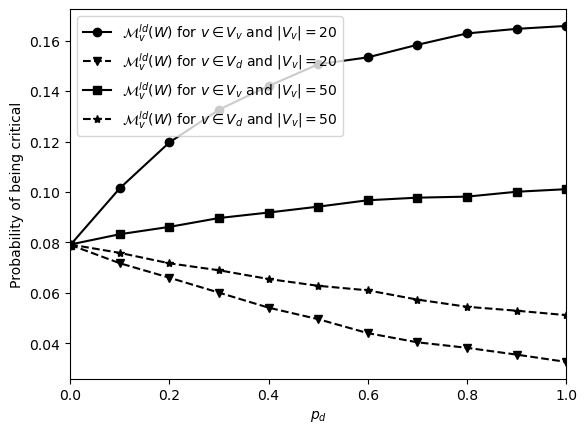

In [6]:
tab_n = np.linspace(0,1,11)
len_tab = len(tab_n)
tab_resc = np.zeros((2, len_tab))

for i in tqdm(range(len(tab_n))):
    proba_d = tab_n[i]
    p_v, p_d = expe_PV(20, 80, 100000, proba_d)
    tab_resc[0, i] = p_v
    tab_resc[1, i] = p_d
    
    
tab_resc_2 = np.zeros((2, len_tab))

for i in tqdm(range(len(tab_n))):
    proba_d = tab_n[i]
    p_v, p_d = expe_PV(50, 50, 100000, proba_d)
    tab_resc_2[0, i] = p_v
    tab_resc_2[1, i] = p_d

plt.plot([n for n in tab_n], tab_resc[0], 'o', ls = '-',label = r'$\mathcal{M}^{ld}_v(W)$ for $v \in V_v$ and $|V_v| = 20$', color="black")
plt.plot([n for n in tab_n], tab_resc[1], 'v', ls = '--',label = r'$\mathcal{M}^{ld}_v(W)$ for $v \in V_d$ and $|V_v| = 20$', color="black")
plt.plot([n for n in tab_n], tab_resc_2[0], 's', ls = '-',label = r'$\mathcal{M}^{ld}_v(W)$ for $v \in V_v$ and $|V_v| = 50$', color="black")
plt.plot([n for n in tab_n], tab_resc_2[1], '*', ls = '--',label = r'$\mathcal{M}^{ld}_v(W)$ for $v \in V_d$ and $|V_v| = 50$', color="black")
plt.legend()
plt.xlim(0,1)
plt.xlabel(r'$p_d$')
plt.ylabel('Probability of being critical')
plt.savefig("figures/criticality_pv.png")
plt.show()


## LD with a complete graph (Section 5)

The following code compute the criticality of voters in LD setting with a complete graph.

In [7]:
def create_bill_complete(n, proba_d):
    '''
    This function create a delegation partition for LD with a complete graph,  
    It select with v_d if voters delegate (v_d_d[i] = 0) or vote directly
    Then we will look at v_1 if they vote directly, v_2 if they delegate and we take care of avoiding self delegations.
    We assume that all voters are of weight 1  and the WVG is with q = 0.5.
    '''
    v_d = np.zeros(n, dtype=int)
    v_d[::] = proba_d <= np.random.rand(n)
    v_1 = np.random.randint(2, size=(n), dtype=int)
    v_2 = np.random.randint(n, size=(n), dtype=int)
    for i in range(n):
        while v_2[i] == i:
            v_2[i] = np.random.randint(n)
                
    return v_d, v_1, v_2


def compute_result_weighted(v_d, v_1, v_2, weights):
    '''
    This function takes as input a delegation instance, and weights of voters, and compute the results of the election in
    this delegation instance
    '''
    n = len(v_d)
    
    # V is the vector of final vote (+1, -1 or 0 if the voter is abstaining)
    v = np.zeros(n)
    
    # We push in q all the delegating voters
    q = []
        
    for i in range(n):
        if v_d[i]:
            v[i] = 2*v_1[i]-1
        else:
            q.append(i)
            
            
    # We propagate the vote of direct voters to the voters delegating to them until we've seen all the voters
    # The idea is similar to a DFS, but in a tree.
    abst = []
    while q != []:
        x = q.pop()
        if x in abst or v[x] != 0:
            continue
        seen = []
        while x not in seen and x not in abst and v[x] == 0:
            seen.append(x)
            x = v_2[x]
        
        if x in seen or x in abst:
            for y in seen:
                if y not in abst:
                    abst.append(y)
        else:
            r = v[x]
            for y in seen:
                v[y] = r
                
    # We compute the results
    r = v.dot(weights)
    
    return r >=0, v

def test_critical_complete_weighted(n, proba_d, weights):
    '''
    This function takes as input the number of voters, the probability to delegate and the weights
    in the LD setting, create a delegation partition, and count the number of voters in each group that are critical.
    We assume that we are in a WVG with q = 0.5. We also assume that weights are natural number between 1 and 9.
    '''
    v_d, v_1, v_2 = create_bill_complete(n, proba_d)
    res, v = compute_result_weighted(v_d, v_1, v_2, weights)
    
    power = np.zeros(10)
    
    # We look for every voter that agree with the result if the result would change if this voter changes his vote.
    for i in range(n):
        res2 = res
        if v[i] != -1 and res == 1:
            v_d_copy = v_d.copy()
            v_d_copy[i] = 1
            v_1_copy = v_1.copy()
            v_1_copy[i] = 0
            res2, _ = compute_result_weighted(v_d_copy, v_1_copy, v_2, weights)
            
        elif v[i] != 1 and res == 0:
            v_d_copy = v_d.copy()
            v_d_copy[i] = 1
            v_1_copy = v_1.copy()
            v_1_copy[i] = 1
            res2, _ = compute_result_weighted(v_d_copy, v_1_copy, v_2, weights)
        if res != res2:
            power[weights[i]-1] += 1
    
    
    return power

The following cell contains the code for the experiment presented in Figure 3 of our paper

In [8]:
    
def expe_complete_weighted(n, n_trys, proba_d):
    """
    
    This function takes as input the number of voters, the probability to delegate and the number of delegation
    instances tested. We construct a WVG with 50 voters of weight 1, 30 voters of weight 2 and 20 voters of weight 5.
    """
    p_v = np.zeros(10)
    c_v = np.zeros(10)
    
    for _ in range(n_trys):
        weights = [1]*50 + [2]*30 + [5]*20
        res_i = test_critical_complete_weighted(n, proba_d, weights)
        for w in weights:
            c_v[w-1] += 1
        for i in range(10):
            p_v[i] += res_i[i]
    
    return p_v/c_v

100%|██████████| 10/10 [33:22<00:00, 200.22s/it]


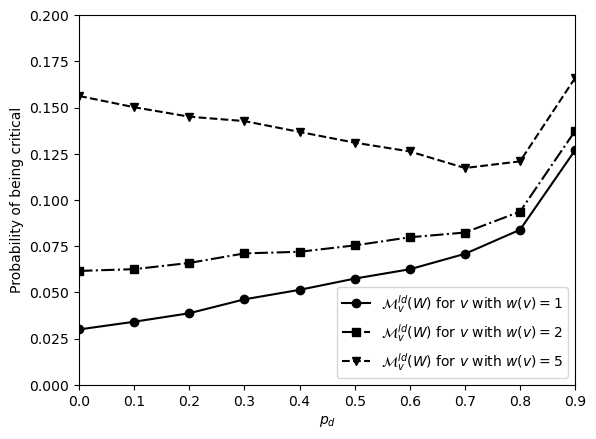

In [10]:
tab_n = np.linspace(0,0.9,10)

len_tab = len(tab_n)
tab_res = np.zeros((3,len_tab))

for i in tqdm(range(len(tab_n))):
    p_d = tab_n[i]
    p_v = expe_complete_weighted(100, 10000, p_d)
    tab_res[0][i] = p_v[0]
    tab_res[1][i] = p_v[1]
    tab_res[2][i] = p_v[4]

plt.plot([n for n in tab_n], tab_res[0], '-o', label = r'$\mathcal{M}^{ld}_v(W)$ for $v$ with $w(v)=1$', color="black")
plt.plot([n for n in tab_n], tab_res[1], '-.s', label = r'$\mathcal{M}^{ld}_v(W)$ for $v$ with $w(v)=2$', color="black")
plt.plot([n for n in tab_n], tab_res[2], '--v', label = r'$\mathcal{M}^{ld}_v(W)$ for $v$ with $w(v)=5$', color="black")

plt.legend()
plt.xlim(0,0.9)
plt.ylim(0,0.2)
plt.xlabel(r'$p_d$')
plt.ylabel('Probability of being critical')
plt.savefig("figures/criticality_ld.png")
plt.show()

## PV-$\alpha$ model (Appendix A.3)

Below, the same code but for the PV-$\alpha$ model

In [11]:
def create_bill_PV_alpha(n_v, n_d):
    '''
    This function create a delegation partition for PV-\alpha, 
    and return the vote of voters in V_v between 0 and 1, 
    and the delegations of voters in V_d.
    We assume that all voters are of weight 1  and the WVG is with q = 0.5.
    '''
    v_v = np.random.randint(2, size=(n_v), dtype=int)
    v_d = np.random.randint(n_v, size=(n_d), dtype=int)
    return v_v, v_d

def test_critical_PV_alpha(n_v, n_d):
    '''
    This function takes as input the number of proxies and delegating voters in PV-\alpha setting,
    create a delegation partition, and count the number of voters in each group that are critical.
    We assume that all voters are of weight 1 and the WVG is with q = 0.5.
    '''
    n = n_v + n_d
    v_v, v_d = create_bill_PV_alpha(n_v, n_d)
    
    # We compute the voting weight of every voters of V_v
    w = np.ones(n_v)
    for x in v_d:
        w[x] += 1
        

    # We compute the result of the election
    vote_for = np.dot(v_v, w)*2 - n
    if vote_for >= 0:
        sign = 1
    elif vote_for < 0:
        sign = 0
        
    
    # For every voter in V_v, we see if they are critical in this situation
    p_v = 0
    for i in range(n_v):
        if v_v[i] == sign:
            copy_v = v_v.copy()
            copy_v[i] = 1 - sign
            vote_for_copy = np.dot(copy_v, w)*2 - n
            if (vote_for_copy >= 0 and sign == 0) or (vote_for_copy < 0 and sign == 1):
                p_v += 1
    
    # For every voter in V_d, we see if they are critical in this situation
    p_d = 0
    if vote_for >= -2 and vote_for < 2:
        for x in v_d:
            if v_v[x] == sign:
                p_d += 1
                
    # Just to avoid dividing by 0
    if n_v == 0:
        n_v = 1
    if n_d == 0:
        n_d = 1
                
    return p_v/n_v, p_d/n_d


def expe_PV_alpha(n_v, n_d, n_trys):
    '''
    This function takes as input the number of proxies and delegating voters in PV-\alpha setting,
    iterates over n_trys delegations partitions and compute the overall criticality of voters in V_v and V_d.
    We assume that all voters are of weight 1 and the WVG is with q = 0.5.
    '''
    p_v = np.zeros(n_trys)
    p_d = np.zeros(n_trys)
    
    for i in range(n_trys):
        p_v_i, p_d_i = test_critical_PV_alpha(n_v, n_d)
        p_v[i] = p_v_i
        p_d[i] = p_d_i
    
    return p_v, p_d

Next, the experiments to see the impact of the number of proxies among voters and the comparisons between the two settings PV and PV-$\alpha$.

24it [16:25, 41.07s/it]


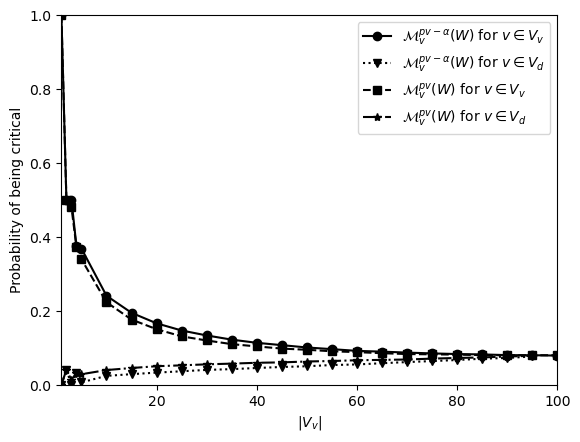

In [12]:
n_voters = 100
tab_n = [1,2,3,4] + [n*5 for n in range(1, n_voters//5+1)]
len_tab = len(tab_n)
tab_res = np.zeros((2, len_tab))
tab_res_alpha = np.zeros((2, len_tab))

for i, n in tqdm(enumerate(tab_n)):
    p_v, p_d = expe_PV(n, n_voters-n, 100000, 0.5)
    tab_res[0, i] = p_v
    tab_res[1, i] = p_d

    p_v, p_d = expe_PV_alpha(n, n_voters-n, 100000)
    tab_res_alpha[0, i] = p_v.mean()
    tab_res_alpha[1, i] = p_d.mean()


plt.plot([n for n in tab_n], tab_res_alpha[0],'o', linestyle='solid' , label = r'$\mathcal{M}^{pv-\alpha}_v(W)$ for $v \in V_v$', color="black")
plt.plot([n for n in tab_n[:-1]], tab_res_alpha[1][:-1], 'v',linestyle='dotted', label = r'$\mathcal{M}^{pv-\alpha}_v(W)$ for $v \in V_d$', color="black")
plt.legend()
plt.xlim(1,n_voters)
plt.xlabel(r'$|V_v|$')
plt.ylim(0,1)
plt.ylabel('Probability of being critical')
plt.plot([n for n in tab_n], tab_res[0], 's', linestyle = 'dashed', label = r'$\mathcal{M}^{pv}_v(W)$ for $v \in V_v$', color="black")
plt.plot([n for n in tab_n[:-1]], tab_res[1][:-1], '*', linestyle = '-.' ,label = r'$\mathcal{M}^{pv}_v(W)$ for $v \in V_d$', color="black")
plt.legend()
# tikzplotlib.save("criticality_pv.tex")
plt.savefig("figures/criticality_pv.png")
plt.show()